## Einleitung

# Projekt „Startup Growth & Funding Trends“  

## Gruppenmitglieder  
- Tom Snider 
- Mark Alexander Nolepa
- Lukas Trölsch
- Silas Bengel

## Kurz-Review des Datensatzes  
- Der Datensatz stammt von Kaggle und trägt den Titel **„Startup Growth & Funding Trends“**. 
- Er enthält Daten zu Start-ups, deren Wachstum und Finanzierungsrunden („funding rounds“) über verschiedene Jahre und Regionen hinweg.  
- Typische Merkmale sind: Start-up-Name, Branche, Finanzierungsbetrag, Datum der Runde, Investor(en) 
- Ziel: Trends im Startup-Ökosystem identifizieren – z. B. wie häufig Finanzierungsrunden stattfinden, wie groß die Beträge sind, welche Branchen und Regionen dominieren.

## Hyperlink zum Datensatz  
[Startup Growth & Funding Trends – Kaggle](https://www.kaggle.com/datasets/samayashar/startup-growth-and-funding-trends/data)

## Unser Geschäftsziel  
- Wir möchten anhand des Datensatzes, **große Mengen an StartUps  ressourcen effizient für Investoren bewerten, um mögliche UNICORNS zu identifizieren**. 
- Zudem wollen wir ein **Empfehlungsmodell** entwickeln, das Investoren unterstützt bei der Frage: *„In welche Start-ups mit hohem Wachstumspotenzial sollte ich investieren?“*  
- Langfristig zielt unser Projekt darauf ab, **Entscheidungshilfen für Gründer und Investoren** bereitzustellen und **Marktchancen frühzeitig zu erkennen**.



## Installation, Importe und Infos
- Im folgenden werden alle **Module installiert**, welche Sie noch nicht bereits Installiert haben. 
- Anschließend werden alle erforderlichen **Programme importiert**, damit wir anschließen mit ihnen arbeiten können. 

In [6]:
import subprocess
import sys

# Methode, die überprüft, ob ein Modul installiert ist, und es bei Bedarf installiert.
# Methode wurde inspiriert durch: https://medium.com/@ryan_forrester_/fixing-no-module-named-error-in-python-3d5f79cbb44c
def installiere_Wenn_Modul_Fehl(Modul: str):
    try:
        # versucht, das Modul zu importieren
        __import__(Modul)
    except ImportError:
        # falls das Modul nicht gefunden wird (ImportError), wird es installiert
        subprocess.check_call([sys.executable, "-m", "pip", "install", Modul])

# Installation der benötigten Module (falls sie fehlen)
installiere_Wenn_Modul_Fehl("kagglehub")
installiere_Wenn_Modul_Fehl("pandas")
installiere_Wenn_Modul_Fehl("seaborn")
installiere_Wenn_Modul_Fehl("matplotlib")

print("Alle benötigten Module sind installiert.")

Alle benötigten Module sind installiert.


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
import pyspark  
import os

print("Der Import ist gelungen!")

Der Import ist gelungen!


In [3]:
df = pd.read_csv('startup_data.csv')  

print("Die benötigen Daten wurden geladen!")  

Die benötigen Daten wurden geladen!


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Startup Name            500 non-null    object 
 1   Industry                500 non-null    object 
 2   Funding Rounds          500 non-null    int64  
 3   Funding Amount (M USD)  500 non-null    float64
 4   Valuation (M USD)       500 non-null    float64
 5   Revenue (M USD)         500 non-null    float64
 6   Employees               500 non-null    int64  
 7   Market Share (%)        500 non-null    float64
 8   Profitable              500 non-null    int64  
 9   Year Founded            500 non-null    int64  
 10  Region                  500 non-null    object 
 11  Exit Status             500 non-null    object 
dtypes: float64(4), int64(4), object(4)
memory usage: 47.0+ KB


In [32]:
df.describe()

,Funding Rounds,Funding Amount (M USD),Valuation (M USD),Revenue (M USD),Employees,Market Share (%),Profitable,Year Founded
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.958000,152.656760,1371.809180,49.321740,2532.092000,5.092940,0.432000,2006.044000
std,1.440968,86.683711,978.226579,29.267605,1385.434921,2.807646,0.495851,9.347128
min,1.000000,0.570000,2.430000,0.120000,12.000000,0.100000,0.000000,1990.000000
25%,2.000000,79.212500,557.027500,22.802500,1382.750000,2.760000,0.000000,1998.000000
50%,3.000000,156.005000,1222.580000,48.800000,2496.500000,5.135000,0.000000,2006.000000
75%,4.000000,226.450000,2052.085000,74.965000,3708.750000,7.552500,1.000000,2014.000000
max,5.000000,299.810000,4357.490000,99.710000,4984.000000,10.000000,1.000000,2022.000000


# StartUp growth & funding values

## Business Problem

**Erkennen potenzieller Unicorns**:
- Unser Ziel ist es, mithilfe der verfügbaren CSV-Daten Unternehmen zu identifizieren, die ein besonders hohes Wachstumspotenzial aufweisen und sich somit zu sogenannten Unicorns (Start-ups mit einer Bewertung über einer Milliarde US-Dollar) entwickeln könnten.

**Risiko-Segmentierung**:
- Darüber hinaus möchten wir durch datenbasierte Analysen eine Risiko-Segmentierung vornehmen, um Start-ups anhand relevanter Faktoren in verschiedene Risikokategorien einzuteilen und so fundierte Investitionsentscheidungen zu unterstützen.

## Warum Data-Science?

### 🎯 Zielsetzung unserer Analyse

- Unsere Analyse verfolgt das Ziel, datenbasierte Entscheidungen im Bereich **Start-up-Investitionen** zu unterstützen und psychologische Verzerrungen bei der Bewertung von Unternehmen zu reduzieren.  

### 🧩 Überblick über große Start-up-Mengen
Angesichts der Vielzahl an bestehenden und neu gegründeten Start-ups ist es für Investoren schwierig, den Überblick zu behalten. Durch den Einsatz datenanalytischer Methoden soll eine strukturierte und effiziente Übersicht über große Start-up-Mengen geschaffen werden.

### 🔍 Herausfiltern besonders relevanter Start-ups
Ein zentrales Anliegen ist es, aus dieser großen Menge **besonders relevante und vielversprechende Start-ups** zu identifizieren – also jene Unternehmen, die überdurchschnittliches Wachstumspotenzial oder einzigartige Marktchancen bieten.

### 🧠 Reduktion von subjektiven Verzerrungen
Traditionelle Investitionsentscheidungen sind oft von **Bauchgefühl** und **kognitiven Verzerrungen (Biases)** beeinflusst. Zu den häufigsten zählen:
- **Confirmation Bias:** Die Tendenz, Informationen so zu interpretieren, dass sie bestehende Überzeugungen bestätigen.  
- **Halo-Effekt:** Die Neigung, ein Unternehmen aufgrund einzelner positiver Merkmale insgesamt zu überschätzen.  
- **Recency Bias:** Jüngste Ereignisse werden überbewertet, während ältere, aber relevante Informationen vernachlässigt werden.  

### 📊 Datenbasierte Investitionsentscheidungen
Durch die Analyse von Start-up-Daten (z. B. Finanzierungsrunden, Branchenzugehörigkeit, Wachstumstrends) soll eine **objektive und nachvollziehbare Entscheidungsgrundlage** geschaffen werden.  
Dies ermöglicht Investoren, Chancen und Risiken faktenbasiert zu bewerten und die Wahrscheinlichkeit erfolgreicher Investments zu erhöhen.


# Daten-Visualisierung


## 📊 Vergleich der Umsätze profitabler und unprofitabler Start-ups

Der folgende Boxplot visualisiert die Verteilung des **Umsatzes (Revenue in Mio. USD)** zwischen profitablen und unprofitablen Start-ups.  
Durch diese Darstellung können wir auf einen Blick erkennen, wie stark sich die Umsatzstrukturen zwischen beiden Gruppen unterscheiden.

### 🔍 Zweck der Visualisierung
- Der **Boxplot** zeigt Median, Quartile und mögliche Ausreißer der Umsatzverteilung für jede Kategorie („Profitabel“ vs. „Unprofitabel“).  
- Zusätzlich sind die **durchschnittlichen Umsatzwerte** oberhalb der Boxen markiert, um einen schnellen quantitativen Vergleich zu ermöglichen.  
- Diese Visualisierung hilft uns zu verstehen, **ob ein klarer Zusammenhang zwischen Profitabilität und Umsatzhöhe besteht**, und liefert somit wertvolle Hinweise auf die Wachstums- und Erfolgsfaktoren von Start-ups.

### 💡 Warum dieser Graph wichtig ist
Ein datenbasierter Vergleich der finanziellen Kennzahlen reduziert subjektive Einschätzungen und ermöglicht eine **objektivere Bewertung von Geschäftsmodellen**.  
So können potenziell erfolgreiche Start-ups frühzeitig identifiziert und Investitionsentscheidungen besser begründet werden.


/var/folders/h6/xnldbwzs6z5g_n88vb8sq7j40000gn/T/ipykernel_40768/4186240759.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Profitable", y=metric, data=df, palette="coolwarm", order=order)
/var/folders/h6/xnldbwzs6z5g_n88vb8sq7j40000gn/T/ipykernel_40768/4186240759.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


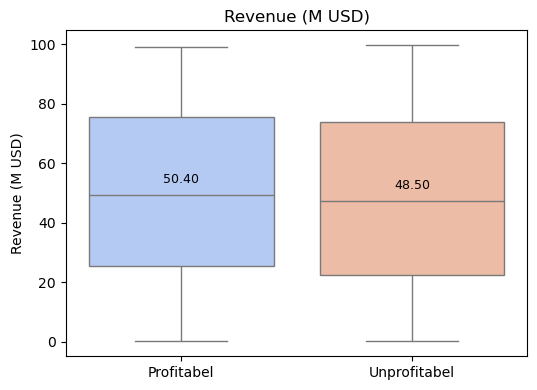

In [4]:
metrics = ["Revenue (M USD)"]
order = [1, 0]
labels = ["Profitabel", "Unprofitabel"]

plt.figure(figsize=(15, 4))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    ax = sns.boxplot(x="Profitable", y=metric, data=df, palette="coolwarm", order=order)
    ax.set_xticklabels(labels)
    ax.set_xlabel("")
    plt.title(f"{metric}")

    for j, prof_value in enumerate(order):
        mean_val = df[df["Profitable"] == prof_value][metric].mean()
        ax.text(j, mean_val + (df[metric].max() * 0.03), f"{mean_val:.2f}", 
                ha='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

## Verteilung Anzahl der StartUps nach Industrie (Säulendiagramm)

/var/folders/h6/xnldbwzs6z5g_n88vb8sq7j40000gn/T/ipykernel_27290/3445576098.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")


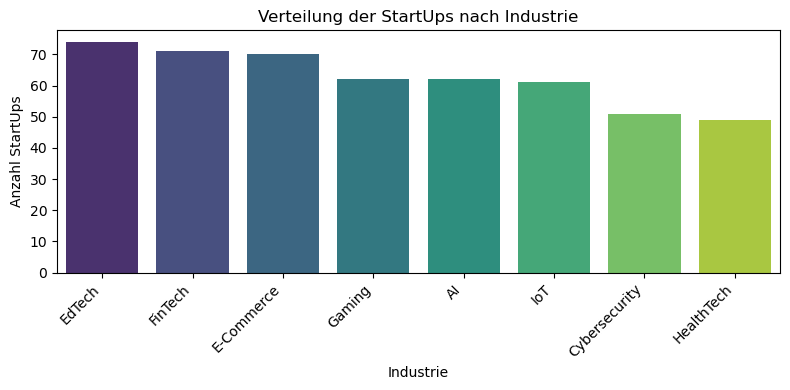

Antwort: Die meisten StartUps stammen aus der Industrie 'EdTech' mit 74 Unternehmen.


In [34]:
# Verteilung Anzahl der StartUps nach Industrie (Säulendiagramm) + kurze Antwort
industry_counts = df['Industry'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")
plt.ylabel("Anzahl StartUps")
plt.xlabel("Industrie")
plt.title("Verteilung der StartUps nach Industrie")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

top_industry = industry_counts.index[0]
top_count = industry_counts.iloc[0]
print(f"Antwort: Die meisten StartUps stammen aus der Industrie '{top_industry}' mit {top_count} Unternehmen.")

## Verteilung der StartUps nach Region

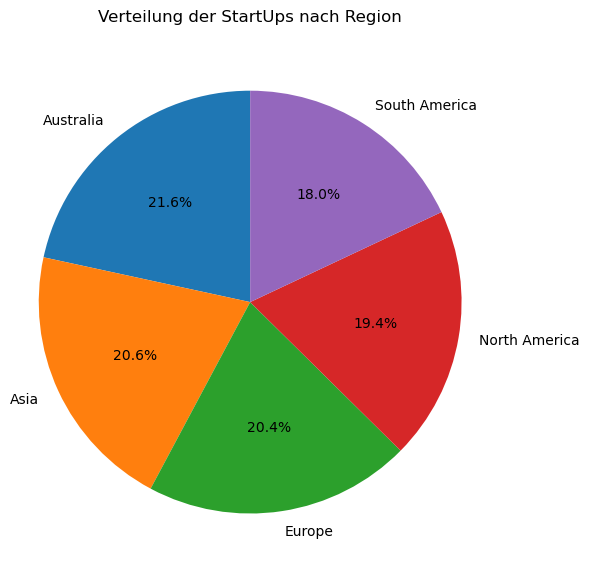

Antwort: Die meisten StartUps stammen aus der Region 'Australia' mit 108 Unternehmen (21.6%).


In [7]:
 #..existing code...
region_counts = df['Region'].value_counts().sort_values(ascending=False)

# ALT (Balkendiagramm)
# plt.figure(figsize=(8,4))
# sns.barplot(x=region_counts.index, y=region_counts.values, palette="viridis")
# plt.ylabel("Anzahl StartUps")
# plt.xlabel("Region")
# plt.title("Verteilung der StartUps nach Region")
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()
# plt.show()

# NEU (Kreisdiagramm)
plt.figure(figsize=(6,6))
plt.pie(
    region_counts.values,
    labels=region_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Verteilung der StartUps nach Region")
plt.axis("equal")
plt.tight_layout()
plt.show()

top_region = region_counts.index[0]
top_count = region_counts.iloc[0]
share = top_count / region_counts.sum() * 100
print(f"Antwort: Die meisten StartUps stammen aus der Region '{top_region}' mit {top_count} Unternehmen ({share:.1f}%).")
# ...existing code...#ä##

# Geschäftsfragen

1) Welche Kennzahlen beeinflussen die Profitabilität?

2) Wie gut kann ein datenbasiertes Modell vorhersagen auf profitable StartUps treffen?

## 1. Feature engineering

## 1.1 Wo entsteht am meisten Umsatz pro investieretem USD


Umsatz-Effizienz (Revenue / Funding) nach Branche (höher = mehr Umsatz pro investiertem USD):
               Mean_Ratio  Median_Ratio  Count
Industry                                      
HealthTech          3.811         0.378     49
Gaming              2.248         0.304     62
FinTech             1.099         0.294     71
IoT                 0.932         0.290     61
EdTech              0.894         0.325     74
AI                  0.756         0.334     62
E-Commerce          0.620         0.339     70
Cybersecurity       0.562         0.347     51

Umsatz-Effizienz nach Region:
               Mean_Ratio  Median_Ratio  Count
Region                                        
Europe              2.074         0.366    102
South America       1.349         0.300     90
Australia           1.047         0.336    108
North America       1.010         0.296     97
Asia                0.991         0.296    103

Top 10 Startups nach Umsatz-Effizienz:
    Startup Name    Industry        

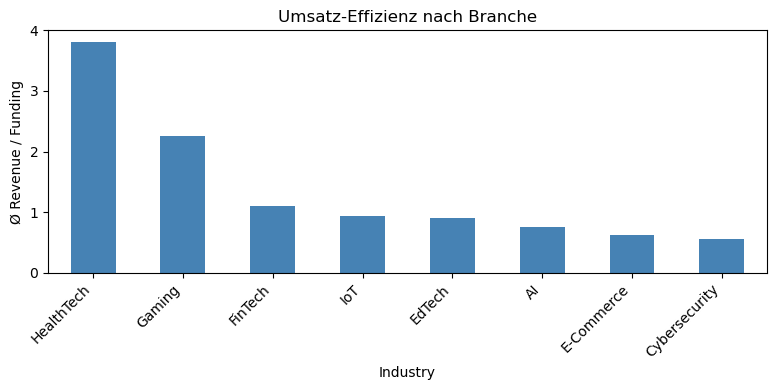

In [35]:
# Frage 1: Wo entsteht am meisten Umsatz pro investiertem USD?
# Kennzahl: Umsatz-Effizienz = Revenue (M USD) / Funding Amount (M USD)

eff_df = df.assign(
    Revenue_per_Invested_USD=df['Revenue (M USD)'] / df['Funding Amount (M USD)']
)

# Aggregation nach Branche und Region
eff_industry = (
    eff_df.groupby('Industry')
    .agg(Mean_Ratio=('Revenue_per_Invested_USD', 'mean'),
         Median_Ratio=('Revenue_per_Invested_USD', 'median'),
         Count=('Revenue_per_Invested_USD', 'size'))
    .sort_values('Mean_Ratio', ascending=False)
    .round(3)
)

eff_region = (
    eff_df.groupby('Region')
    .agg(Mean_Ratio=('Revenue_per_Invested_USD', 'mean'),
         Median_Ratio=('Revenue_per_Invested_USD', 'median'),
         Count=('Revenue_per_Invested_USD', 'size'))
    .sort_values('Mean_Ratio', ascending=False)
    .round(3)
)

# Top 10 einzelne Startups nach Effizienz
top_startups = (
    eff_df[['Startup Name','Industry','Region','Funding Amount (M USD)','Revenue (M USD)','Revenue_per_Invested_USD']]
    .sort_values('Revenue_per_Invested_USD', ascending=False)
    .head(10)
    .round(3)
)

print("Umsatz-Effizienz (Revenue / Funding) nach Branche (höher = mehr Umsatz pro investiertem USD):")
print(eff_industry)
print("\nUmsatz-Effizienz nach Region:")
print(eff_region)
print("\nTop 10 Startups nach Umsatz-Effizienz:")
print(top_startups)

best_industry = eff_industry.index[0]
best_industry_value = eff_industry.iloc[0]['Mean_Ratio']
best_region = eff_region.index[0]
best_region_value = eff_region.iloc[0]['Mean_Ratio']

print(f"\nAntwort: Die höchste durchschnittliche Umsatz-Effizienz liegt in der Branche '{best_industry}' (Ø {best_industry_value:.3f} Umsatz pro investiertem USD).")
print(f"Regional erzielt '{best_region}' die beste Effizienz (Ø {best_region_value:.3f}).")

# Optional: einfache Visualisierung nach Branche
plt.figure(figsize=(8,4))
eff_industry['Mean_Ratio'].plot(kind='bar', color='steelblue')
plt.ylabel('Ø Revenue / Funding')
plt.title('Umsatz-Effizienz nach Branche')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 1.2 Wie effienzient wird Personal skaliert?

➤ Umsatz-Effizienz (Revenue pro Mitarbeiter) nach Branche:
               Mean_Rev_per_Emp  Median_Rev_per_Emp  Count
Industry                                                  
Cybersecurity             0.105               0.021     51
HealthTech                0.060               0.019     49
E-Commerce                0.052               0.024     70
AI                        0.045               0.024     62
Gaming                    0.041               0.020     62
FinTech                   0.039               0.020     71
EdTech                    0.033               0.018     74
IoT                       0.027               0.014     61

➤ Umsatz-Effizienz nach Region:
               Mean_Rev_per_Emp  Median_Rev_per_Emp  Count
Region                                                    
Asia                      0.092               0.022    103
North America             0.043               0.021     97
Australia                 0.043               0.018    108
Europe                 

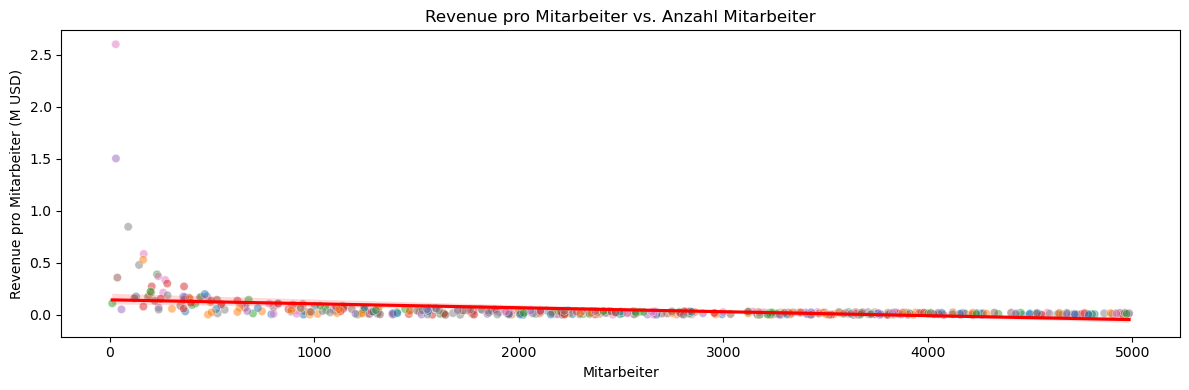

In [37]:
# Analyse 1.3: Effizienz der Personalskalierung (Revenue-Fokus)
# Kennzahl: Revenue_per_Employee = Umsatz (M USD) je Mitarbeiter

base_df = eff_df.copy() if 'eff_df' in globals() else df.copy()

work_emp = base_df.copy()
work_emp['Employees_nonzero'] = work_emp['Employees'].replace(0, np.nan)
work_emp['Revenue_per_Employee'] = work_emp['Revenue (M USD)'] / work_emp['Employees_nonzero']

# Aggregation nach Branche und Region
agg_industry = (
    work_emp.groupby('Industry')
    .agg(
        Mean_Rev_per_Emp=('Revenue_per_Employee', 'mean'),
        Median_Rev_per_Emp=('Revenue_per_Employee', 'median'),
        Count=('Revenue_per_Employee', 'size')
    )
    .sort_values('Mean_Rev_per_Emp', ascending=False)
    .round(3)
)

agg_region = (
    work_emp.groupby('Region')
    .agg(
        Mean_Rev_per_Emp=('Revenue_per_Employee', 'mean'),
        Median_Rev_per_Emp=('Revenue_per_Employee', 'median'),
        Count=('Revenue_per_Employee', 'size')
    )
    .sort_values('Mean_Rev_per_Emp', ascending=False)
    .round(3)
)

top_startups_emp = (
    work_emp[['Startup Name','Industry','Region','Employees','Revenue (M USD)','Revenue_per_Employee']]
    .sort_values('Revenue_per_Employee', ascending=False)
    .head(10)
    .round(3)
)

print("➤ Umsatz-Effizienz (Revenue pro Mitarbeiter) nach Branche:")
print(agg_industry.head(10))
print("\n➤ Umsatz-Effizienz nach Region:")
print(agg_region)
print("\n➤ Top 10 Startups nach Revenue pro Mitarbeiter:")
print(top_startups_emp)

best_ind = agg_industry.index[0]
best_ind_val = agg_industry.iloc[0]['Mean_Rev_per_Emp']
best_reg = agg_region.index[0]
best_reg_val = agg_region.iloc[0]['Mean_Rev_per_Emp']

# Korrelationen (Spearman) mit Revenue_per_Employee
corr_vars = ['Employees','Funding Amount (M USD)','Valuation (M USD)','Revenue (M USD)','Profitable']
corr_df = work_emp[corr_vars + ['Revenue_per_Employee']].corr(method='spearman')['Revenue_per_Employee'].drop('Revenue_per_Employee').round(3)

print("\nSpearman-Korrelationen mit Revenue_per_Employee (positiv = steigt mit Kennzahl):")
print(corr_df)

print("\nAntwort 1.3:")
print(
    f"Die höchste durchschnittliche Umsatz-Effizienz (Revenue pro Mitarbeiter) liegt in der Branche '{best_ind}' (Ø {best_ind_val:.3f} M USD je Mitarbeiter) "
    f"und regional in '{best_reg}' (Ø {best_reg_val:.3f}). "
    "Korrelationen zeigen, ob größere Teams oder höhere Bewertungen mit Effizienz zusammenhängen. "
    "Interpretation: "
    + ("Mehr Mitarbeiter senken Effizienz. " if corr_df['Employees'] < 0 else "Mehr Mitarbeiter erhöhen Effizienz oder neutral. ")
    + ("Höhere Bewertung korreliert positiv. " if corr_df['Valuation (M USD)'] > 0 else "Bewertung zeigt keinen klar positiven Zusammenhang. ")
    + ("Höherer Gesamtumsatz setzt sich teils in Effizienz um. " if corr_df['Revenue (M USD)'] > 0 else "Gesamtumsatz steigert nicht zwingend Effizienz. ")
)

# Optionale Visualisierung
plt.figure(figsize=(12,4))
sns.scatterplot(data=work_emp, x='Employees', y='Revenue_per_Employee', hue='Industry', legend=False, alpha=0.5)
sns.regplot(data=work_emp, x='Employees', y='Revenue_per_Employee', scatter=False, color='red')
plt.title('Revenue pro Mitarbeiter vs. Anzahl Mitarbeiter')
plt.xlabel('Mitarbeiter')
plt.ylabel('Revenue pro Mitarbeiter (M USD)')
plt.tight_layout()
plt.show()

## 1.3 Hebt ein höherer Marktanteil die Bewertung, Profitabilität und Kapital-Effizienz?

Spearman-Korrelationen mit Marktanteil (positiv = steigt mit Marktanteil):
Valuation (M USD)           0.106
Revenue_per_Invested_USD   -0.059
Profitable                  0.118
Name: Market Share (%), dtype: float64

Kennzahlen nach Marktanteils-Quartilen:
                      Ø_Bewertung  Ø_Kapital_Effizienz  \
Market Share Quartil                                     
Q1 (niedrig)             1218.201                1.503   
Q2                       1333.876                0.908   
Q3                       1389.514                1.394   
Q4 (hoch)                1546.571                1.360   

                      IPO_Profitabilität_Rate    n  
Market Share Quartil                                
Q1 (niedrig)                            0.381  126  
Q2                                      0.347  124  
Q3                                      0.512  125  
Q4 (hoch)                               0.488  125  


/var/folders/h6/xnldbwzs6z5g_n88vb8sq7j40000gn/T/ipykernel_27290/3039187561.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work.groupby('Market Share Quartil')
/var/folders/h6/xnldbwzs6z5g_n88vb8sq7j40000gn/T/ipykernel_27290/3039187561.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_ms.reset_index(), x='Market Share Quartil', y='IPO_Profitabilität_Rate', palette='viridis')


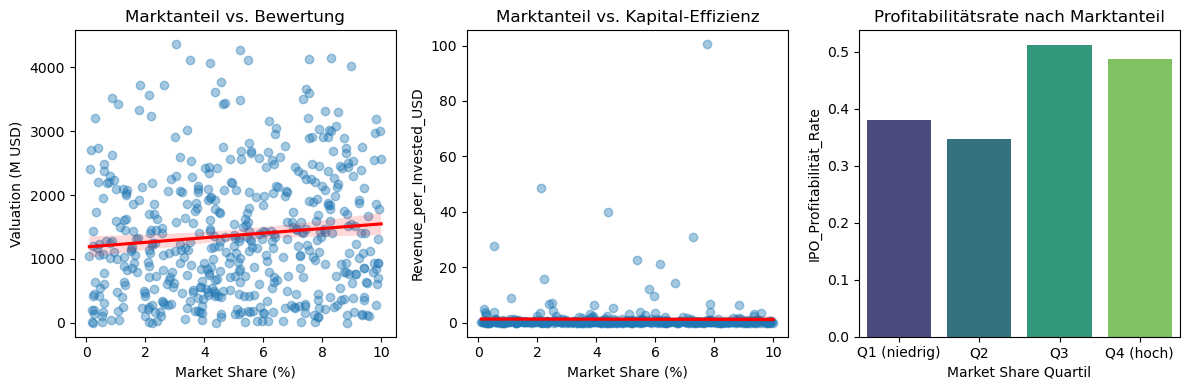


Antwort 1.4: Ein höherer Marktanteil korreliert positiv mit der Bewertung (0.106), negativ/neutral mit der Kapital-Effizienz (-0.059) und positiv mit der Profitabilität (0.118). Die Quartile stützen diesen Trend.


In [41]:
# 1.4 Hebt ein höherer Marktanteil die Bewertung, Profitabilität und Kapital-Effizienz?

# Arbeitsdaten mit Kapital-Effizienz (Revenue/Funding)
work = eff_df.copy() if 'eff_df' in globals() else df.assign(
    Revenue_per_Invested_USD=df['Revenue (M USD)'] / df['Funding Amount (M USD)']
).copy()

# Korrelationen (Spearman) zwischen Marktanteil und Zielgrößen
corr = (
    work[['Market Share (%)', 'Valuation (M USD)', 'Revenue_per_Invested_USD', 'Profitable']]
    .corr(method='spearman')
    .loc['Market Share (%)']
    .drop('Market Share (%)')
    .round(3)
)

print("Spearman-Korrelationen mit Marktanteil (positiv = steigt mit Marktanteil):")
print(corr)

# Quartile des Marktanteils und aggregierte Metriken
work['Market Share Quartil'] = pd.qcut(
    work['Market Share (%)'], 4,
    labels=['Q1 (niedrig)', 'Q2', 'Q3', 'Q4 (hoch)'],
    duplicates='drop'
)

agg_ms = (
    work.groupby('Market Share Quartil')
    .agg(
        Ø_Bewertung=('Valuation (M USD)', 'mean'),
        Ø_Kapital_Effizienz=('Revenue_per_Invested_USD', 'mean'),
        IPO_Profitabilität_Rate=('Profitable', 'mean'),
        n=('Profitable', 'size')
    )
    .round(3)
)

print("\nKennzahlen nach Marktanteils-Quartilen:")
print(agg_ms)

# Kurze Visualisierung
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.regplot(data=work, x='Market Share (%)', y='Valuation (M USD)', scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title('Marktanteil vs. Bewertung')

plt.subplot(1,3,2)
sns.regplot(data=work, x='Market Share (%)', y='Revenue_per_Invested_USD', scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title('Marktanteil vs. Kapital-Effizienz')

plt.subplot(1,3,3)
sns.barplot(data=agg_ms.reset_index(), x='Market Share Quartil', y='IPO_Profitabilität_Rate', palette='viridis')
plt.title('Profitabilitätsrate nach Marktanteil')
plt.tight_layout()
plt.show()

# Fazit in einem Satz
trend_bew = "positiv" if corr['Valuation (M USD)'] > 0 else "negativ/neutral"
trend_eff = "positiv" if corr['Revenue_per_Invested_USD'] > 0 else "negativ/neutral"
trend_prof = "positiv" if corr['Profitable'] > 0 else "negativ/neutral"

print(
    f"\nAntwort 1.4: Ein höherer Marktanteil korreliert {trend_bew} mit der Bewertung "
    f"({corr['Valuation (M USD)']}), {trend_eff} mit der Kapital-Effizienz "
    f"({corr['Revenue_per_Invested_USD']}) und {trend_prof} mit der Profitabilität "
    f"({corr['Profitable']}). Die Quartile stützen diesen Trend."
)

In [15]:
duplicates = df.duplicated().sum()
print(f"Anzahl doppelter Zeilen: {duplicates}")
if duplicates > 0:
    display(df[df.duplicated()])


Anzahl doppelter Zeilen: 0


In [17]:
# Übersicht über Datentypen
print(df.dtypes)

# Prüfen, ob Spalten numerisch konvertierbar sind
for col in df.columns:
    try:
        df[col].astype(float)
    except:
        pass  # kein numerischer Datentyp


Startup Name               object
Industry                   object
Funding Rounds              int64
Funding Amount (M USD)    float64
Valuation (M USD)         float64
Revenue (M USD)           float64
Employees                   int64
Market Share (%)          float64
Profitable                  int64
Year Founded                int64
Region                     object
Exit Status                object
dtype: object


## 2 Ausreißer

In den folgenden Schritten identifizieren wir systematisch Ausreißer für numerische (nicht-binäre) Features mittels der IQR‑Methode.
Kurzüberblick der Abläufe:

- Berechnung von Q1 (25%) und Q3 (75%) und des IQR = Q3 − Q1; Festlegung der Schwellen für 1.5×IQR (moderate Ausreißer) und 3.0×IQR (extreme Ausreißer).
- Erstellung boolescher Masken pro Feature/Zeile: True = Wert ist außerhalb der jeweiligen Schwelle.
- Aufbau einer zusammenfassenden Tabelle mit Q1/Q3/IQR sowie Anzahl und Prozent der Ausreißer pro Feature.
- Identifikation der betroffenen Zeilen (Top N) und optionale Visualisierung als Heatmap, um Muster über Features hinweg zu sehen.

Hinweis: Ausreißer sollten nicht automatisch gelöscht werden. Zuerst kontextuell prüfen (Messfehler, echte Spezialfälle), dann entscheiden: markieren, transformieren (z.B. log), winsorisieren (Extremwerte begrenzen) oder robustere Methoden (MAD, IsolationForest) verwenden.


In [8]:
# Ausreißer-Identifikation (IQR-Methode) auf numerischen Features
# Ziel: Für jede numerische (nicht-binäre) Spalte IQR berechnen und Ausreißer nach 1.5x und 3x IQR markieren.

# Numerische Spalten bestimmen und binäre Variablen (z.B. Profitable) ausschließen
_numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # alle numerischen Spalten
_binary_cols = [c for c in _numeric_cols if df[c].dropna().nunique() <= 2]  # Spalten mit <=2 eindeutigen Werten (binär)
num_cols_iqr = [c for c in _numeric_cols if c not in _binary_cols]  # nur echte numerische Features (keine 0/1 Indikatoren)

# IQR-Grenzen berechnen und Ausreißer-Masken (1.5x IQR und 3x IQR) erstellen
outlier_records = []  # speichern von Q1/Q3/IQR und Ausreißerstatistiken pro Feature
outlier_mask_15 = pd.DataFrame(False, index=df.index, columns=num_cols_iqr)  # bool-matrix: True = Ausreißer (1.5x)
outlier_mask_30 = pd.DataFrame(False, index=df.index, columns=num_cols_iqr)  # bool-matrix: True = Ausreißer (3x)

for col in num_cols_iqr:
    # Quartile berechnen (Q1=25%, Q3=75%) und IQR bestimmen
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1  # Interquartilsabstand (Robuste Maßzahl für Streuung)

    # Falls IQR nicht definiert (z.B. konstante Spalte) → keine Schwellen setzen
    if pd.isna(iqr) or iqr == 0:
        lower15 = upper15 = lower30 = upper30 = np.nan
        cnt15 = cnt30 = 0
    else:
        # Schwellen für moderate (1.5x) und extreme (3x) Ausreißer festlegen
        lower15, upper15 = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        lower30, upper30 = q1 - 3.0 * iqr, q3 + 3.0 * iqr
        # Masken setzen: True, wenn Wert außerhalb der Grenzen liegt
        outlier_mask_15[col] = (df[col] < lower15) | (df[col] > upper15)
        outlier_mask_30[col] = (df[col] < lower30) | (df[col] > upper30)
        # Anzahl der Ausreißer pro Feature zählen (für Reporting)
        cnt15 = int(outlier_mask_15[col].sum())
        cnt30 = int(outlier_mask_30[col].sum())

    # Statistik-Eintrag für dieses Feature (wird später zu einem DataFrame)
    outlier_records.append({
        'Feature': col,
        'Q1': q1, 'Q3': q3, 'IQR': iqr,
        'Lower_1.5IQR': lower15, 'Upper_1.5IQR': upper15,
        'Lower_3IQR': lower30, 'Upper_3IQR': upper30,
        'Outliers_1.5IQR': cnt15,
        'Outliers_3IQR': cnt30,
        'Outlier_% (1.5IQR)': round(cnt15 / len(df) * 100, 2) if len(df) else 0.0,
    })

# Zusammenfassung: DataFrame mit den Ausreißer-Statistiken pro Feature
outlier_summary = (
    pd.DataFrame(outlier_records)
    .set_index('Feature')
    .sort_values('Outliers_1.5IQR', ascending=False)
)

print("Ausreißer-Zusammenfassung pro Feature (IQR-basiert):")
print(outlier_summary)

# Zeilen mit den meisten Ausreißern (über alle Features) bestimmen
row_outlier_counts = outlier_mask_15.sum(axis=1)  # Anzahl einziger Features mit Ausreißer pro Zeile
rows_with_outliers = row_outlier_counts[row_outlier_counts > 0].sort_values(ascending=False)

if not rows_with_outliers.empty:
    # Kontextspalten auswählen, falls vorhanden (für bessere Interpretation der betroffenen Zeilen)
    key_cols = [c for c in ['Startup Name', 'Industry', 'Region', 'Exit Status'] if c in df.columns]
    preview_cols = key_cols + num_cols_iqr
    top_rows = rows_with_outliers.index[:15]  # Top 15 problematische Zeilen

    print("\nTop-Zeilen mit den meisten Ausreißern (1.5x IQR):")
    display(
        df.loc[top_rows, preview_cols]
          .assign(Outlier_Count=row_outlier_counts.loc[top_rows])
          .sort_values('Outlier_Count', ascending=False)
    )
else:
    print("\nKeine Ausreißer nach 1.5x IQR-Regel gefunden.")


Ausreißer-Zusammenfassung pro Feature (IQR-basiert):
                               Q1         Q3        IQR  Lower_1.5IQR  \
Feature                                                                 
Valuation (M USD)        557.0275  2052.0850  1495.0575   -1685.55875   
Funding Rounds             2.0000     4.0000     2.0000      -1.00000   
Funding Amount (M USD)    79.2125   226.4500   147.2375    -141.64375   
Revenue (M USD)           22.8025    74.9650    52.1625     -55.44125   
Employees               1382.7500  3708.7500  2326.0000   -2106.25000   
Market Share (%)           2.7600     7.5525     4.7925      -4.42875   
Year Founded            1998.0000  2014.0000    16.0000    1974.00000   

                        Upper_1.5IQR  Lower_3IQR  Upper_3IQR  Outliers_1.5IQR  \
Feature                                                                         
Valuation (M USD)         4294.67125  -3928.1450   6537.2575                1   
Funding Rounds               7.00000     -4.00

,Startup Name,Industry,Region,Exit Status,Funding Rounds,Funding Amount (M USD),Valuation (M USD),Revenue (M USD),Employees,Market Share (%),Year Founded,Outlier_Count
384,Startup_385,Gaming,Asia,Private,2,293.25,4357.49,47.48,4001,3.03,2022,1


In [5]:
import numpy as np

numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    print(f"{col}: {outliers} potenzielle Ausreißer")


Funding Rounds: 0 potenzielle Ausreißer
Funding Amount (M USD): 0 potenzielle Ausreißer
Valuation (M USD): 1 potenzielle Ausreißer
Revenue (M USD): 0 potenzielle Ausreißer
Employees: 0 potenzielle Ausreißer
Market Share (%): 0 potenzielle Ausreißer
Profitable: 0 potenzielle Ausreißer
Year Founded: 0 potenzielle Ausreißer


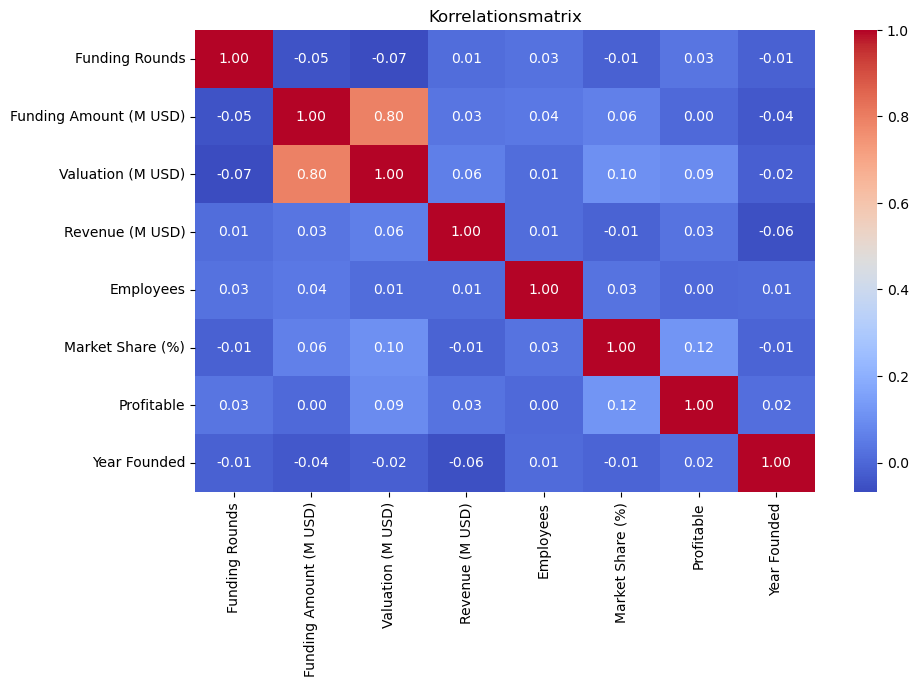

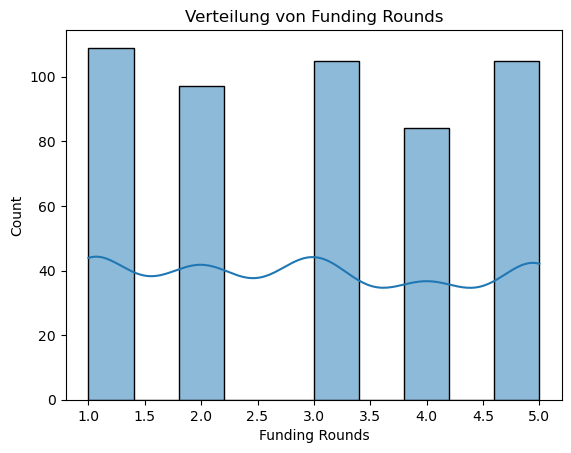

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap der Korrelationen
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korrelationsmatrix")
plt.show()

# Beispiel-Verteilung für erste numerische Spalte
num_col = numeric_cols[0]
sns.histplot(df[num_col], kde=True)
plt.title(f"Verteilung von {num_col}")
plt.show()


In [10]:
print("🔍 Datenqualitäts-Zusammenfassung:")
print(f"- Zeilen: {df.shape[0]}, Spalten: {df.shape[1]}")
print(f"- Fehlende Werte: {df.isnull().sum().sum()}")
# Sicherstellen, dass 'duplicates' definiert ist (falls vorherige Zelle nicht ausgeführt wurde)
if 'duplicates' not in globals():
	duplicates = df.duplicated().sum()
print(f"- Doppelte Zeilen: {duplicates}")
print(f"- Numerische Spalten: {len(numeric_cols)}")
print(f"- Kategorische Spalten: {len(df.select_dtypes(exclude=np.number).columns)}")


🔍 Datenqualitäts-Zusammenfassung:
- Zeilen: 500, Spalten: 12
- Fehlende Werte: 0
- Doppelte Zeilen: 0
- Numerische Spalten: 8
- Kategorische Spalten: 4
